# Initial model

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        ### vocab_size - size of vocbulary + 1 (padding)
        ### embedding_dim in our case 25
        
        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 1, 
                    out_channels = 16, 
                    kernel_size = (fs, embedding_dim)) 
                for fs in [2, 3, 4, 5]
            ]
        )

        self.fc = nn.Linear(4 * 16, 1)
        ### 1 because binary classification
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)

# Improved model

In [2]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import numpy as np

In [5]:
import gensim.downloader as api


fasttext = api.load('glove-twitter-25')

In [6]:
import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10): ### to remove some rare words
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        ### removed all links
        ### kept only letters

        ### replace two spaces with one space
        
        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')  ### unique word
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text): ### encoding text
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext): ### returning vectors for words
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [7]:
import pandas as pd


df = pd.read_csv('/kaggle/input/imdb-dataset/IMDB Dataset.csv')

In [8]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [9]:
df = pd.read_csv('/kaggle/input/imdb-dataset/IMDB Dataset.csv')
df_train, df_test = np.split(df, [45000], axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
### building vocabulary from training data
train_vocab = Vocabulary(df_train['review'].values, min_freq=5)
pad_idx = len(train_vocab.vocabulary)

In [12]:
from torch.utils.data import Dataset


class IMDB(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab
        self.label2idx = {'positive': 0, 'negative': 1}

    def __getitem__(self, idx):
        text = self.df['review'].iloc[idx]
        label = self.label2idx[self.df['sentiment'].iloc[idx]]
        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])
        return text, label

    def __len__(self):
        return len(self.df)

In [13]:
train_dataset = IMDB(df_train, train_vocab)
test_dataset = IMDB(df_test, train_vocab)

In [14]:
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(train_vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

In [15]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [16]:
# https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(fs, embedding_dim)),
                nn.BatchNorm2d(64),
                nn.ReLU()
            )
            for fs in [2, 3, 4, 5]
        ])
        self.fc = nn.Linear(4 * 64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in x]
        x = self.dropout(torch.cat(x, dim=1))
        return self.fc(x)

In [17]:
vectors = train_vocab.build_vectors(fasttext)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = TextCNN(vocab_size=len(train_vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)
model = model.to(device)

cuda:0
Tesla P100-PCIE-16GB


In [19]:
vectors.shape

(37529, 25)

In [20]:
model.embedding.weight.shape

torch.Size([37530, 25])

In [21]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [22]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.3254,  0.2012,  0.4525,  ..., -0.2660, -0.6399, -0.2558],
        [-0.0480, -0.6184, -0.2552,  ..., -0.9464, -0.3942,  0.0959],
        ...,
        [-0.5433,  1.3834,  0.0331,  ...,  0.6798,  1.1357,  0.4124],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', requires_grad=True)

In [23]:
model.embedding.weight.shape

torch.Size([37530, 25])

In [24]:
from tqdm import tqdm


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model) -> float:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [25]:
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [26]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):

    # Convert tensors to CPU and lists
    train_accuracy = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_accuracy]
    valid_accuracy = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in valid_accuracy]

    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [28]:
import torch.nn as nn
from torch.optim import Adam

In [29]:
loss_fn = nn.BCEWithLogitsLoss()

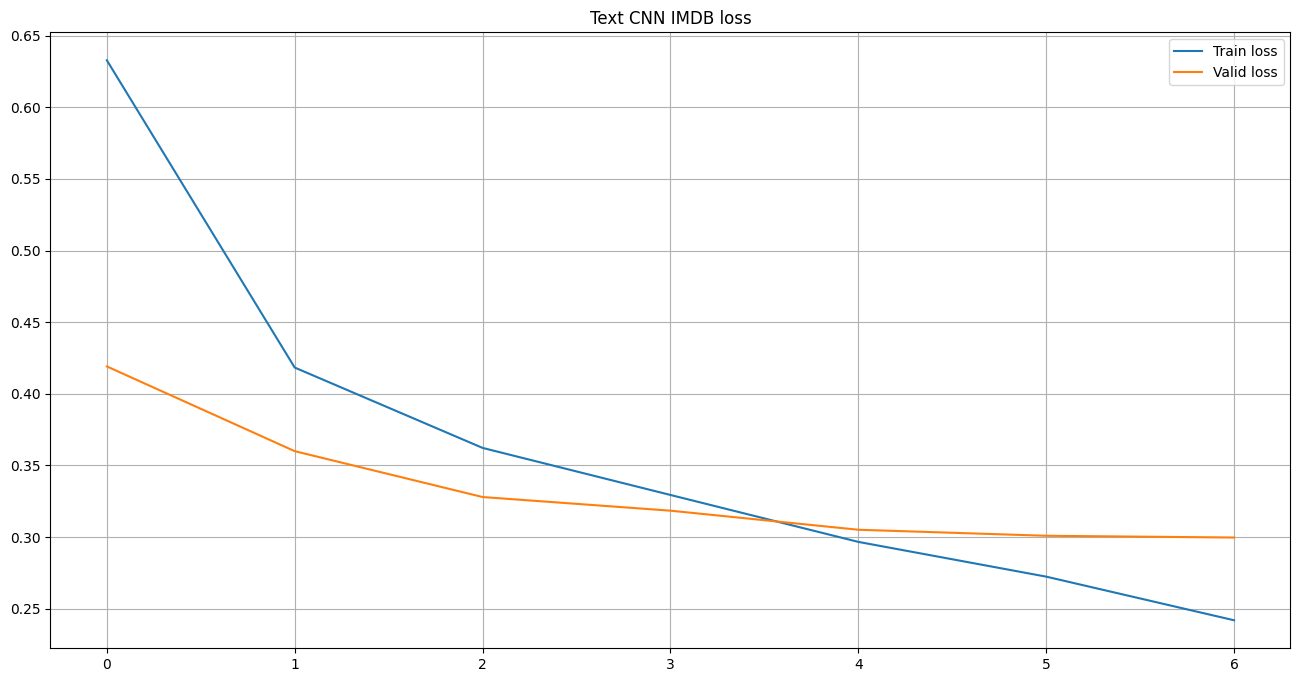

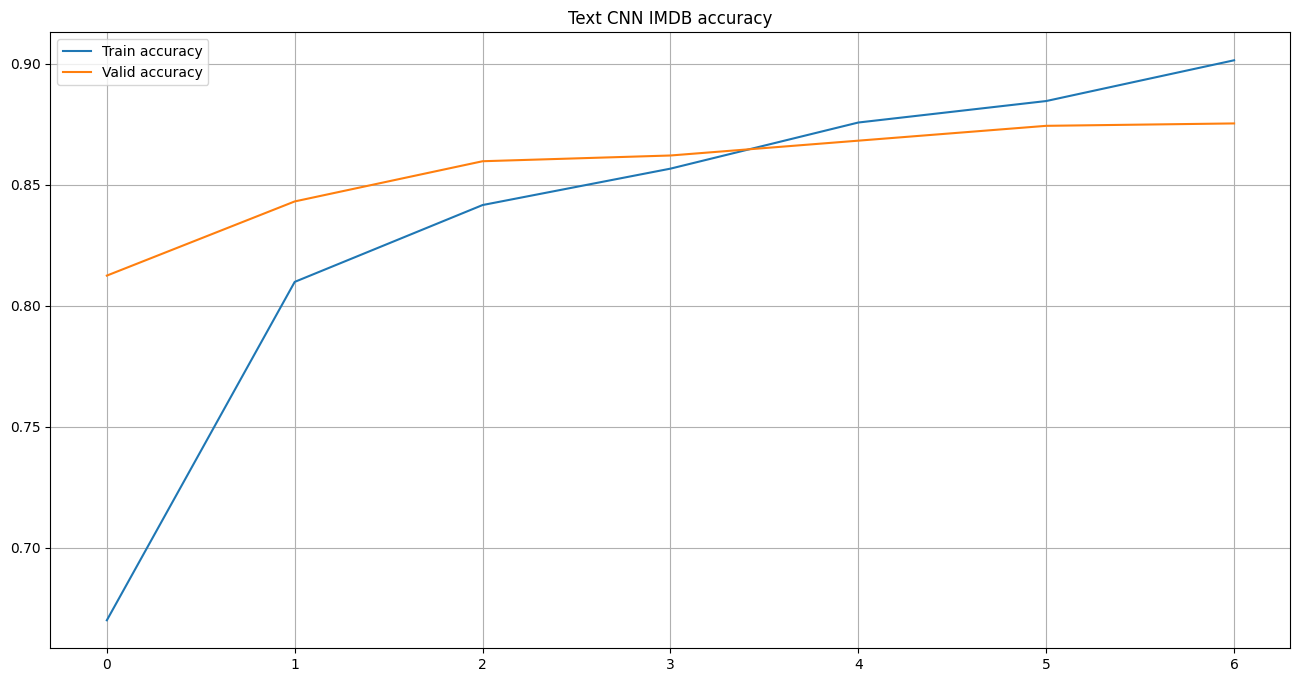

In [30]:
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

whole_train_valid_cycle(model, 7, 'Text CNN IMDB')

In [46]:
### saving predictions for test data

model.eval()

predictions = []

with torch.no_grad():
    for x, _ in test_loader: 
        x = x.to(device)  
        outputs = model(x) 
        preds = torch.sigmoid(outputs).squeeze(1)  ### sigmoid activation
        preds = torch.round(preds)  ### converting probabilities to binary labels
        predictions.append(preds.cpu())

predictions = torch.cat(predictions)  ### size: (5000,)

torch.save(predictions, 'test_predictions.pt')

Predictions saved to 'test_predictions.pt'
